In [2]:
import sys
import datacube
import numpy as np
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

sys.path.append('../../Scripts')
from dea_datahandling import load_ard
from dea_datahandling import mostcommon_crs
from dea_dask import create_local_dask_cluster
from dea_plotting import xr_animation
from dea_coastaltools import tidal_tag

dc = datacube.Datacube(app='Animated tides')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geopolygon = select_on_a_map(height='600px',
                             layers=(basemap,),
                             center=(-26, 135), 
                             zoom=4) 

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [76]:
bands=['nbar_red', 'nbar_green', 'nbar_blue']
# bands=['nbar_swir_1', 'nbar_nir', 'nbar_green']

# Configure local dask cluster
create_local_dask_cluster()

# Obtain native CRS 
crs = mostcommon_crs(dc=dc, 
                     product='ga_ls5t_ard_3', 
                     query={'time': '1990', 
                            'geopolygon': geopolygon})

# Standard Landsat
query = {
    'geopolygon': geopolygon,
    'time': ('2000', '2020'),
    'measurements': bands,
    'resampling': {'fmask': 'nearest', 
                   'oa_fmask': 'nearest', 
                   '*': 'nearest'},
    'output_crs': crs,
    'resolution': (-30, 30),
    'group_by': 'solar_day',
    'dask_chunks': {'time': 1, 'x': 2000, 'y': 2000}
}

# # Landsat upscaled res
# query = {
#     'geopolygon': geopolygon,
#     'time': ('1986', '2020'),
#     'measurements': bands,
#     'resampling': {'fmask': 'nearest', 
#                    'oa_fmask': 'nearest', 
#                    '*': 'cubic'},
#     'output_crs': crs,
#     'resolution': (-15, 15),
#     'group_by': 'solar_day',
#     'dask_chunks': {'time': 1, 'x': 2000, 'y': 2000}
# }

# # Sentinel-2 10m
# crs = mostcommon_crs(dc=dc, 
#                      product='s2a_ard_granule', 
#                      query={'time': '2018', 
#                             'geopolygon': geopolygon})

# query = {
#     'geopolygon': geopolygon,
#     'time': ('2016', '2020'),
#     'measurements': bands,
#     'resampling': {'fmask': 'nearest', 
#                    'oa_fmask': 'nearest', 
#                    '*': 'cubic'},
#     'output_crs': crs,
#     'resolution': (-10, 10),
#     'group_by': 'solar_day',
#     'dask_chunks': {'time': 1, 'x': 2000, 'y': 2000}
# }

ds_tides = load_ard(dc=dc,
                 products=[
                           'ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3', 
#                            's2a_ard_granule', 's2a_ard_granule'
                          ],
                 min_gooddata=0.95,
                 ls7_slc_off=False,
                 mask_pixel_quality=True,
                 **query)

# Load data into memory
ds_tides = ds_tides.compute()
ds_tides




/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46189 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:41028 Dashboard: /proxy/46189/status,Cluster Workers: 1 Cores: 8 Memory: 30.67 GB


../../Scripts/dea_datahandling.py:589: UserWarning: Multiple UTM zones ['epsg:32656', 'epsg:32655'] were returned for this query. Defaulting to the most common zone: epsg:32656
  UserWarning)
../../Scripts/dea_datahandling.py:286: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls8c_ard_3
Counting good quality pixels for each time step
Filtering to 181 out of 691 time steps with at least 95.0% good quality pixels
Applying pixel quality/cloud mask
Returning 181 time steps as a dask array


<xarray.Dataset>
Dimensions:      (time: 181, x: 210, y: 212)
Coordinates:
    spatial_ref  int32 32656
  * time         (time) datetime64[ns] 2000-03-03T23:51:41.031846 ... 2020-06...
  * x            (x) float64 1.293e+05 1.293e+05 ... 1.355e+05 1.356e+05
  * y            (y) float64 -2.412e+06 -2.412e+06 ... -2.418e+06 -2.418e+06
Data variables:
    nbar_red     (time, y, x) float32 885.0 575.0 853.0 ... 1408.0 1418.0 1626.0
    nbar_green   (time, y, x) float32 893.0 649.0 855.0 ... 1370.0 1334.0 1502.0
    nbar_blue    (time, y, x) float32 631.0 475.0 631.0 ... 1040.0 1036.0 1112.0
Attributes:
    crs:           epsg:32656
    grid_mapping:  spatial_ref

## Tidal modelling

In [77]:
ds_tides = tidal_tag(ds_tides, ebb_flow=True, swap_dims=True)

Setting tide modelling location from dataset centroid: 149.45, -21.80
Modelling tidal phase (e.g. ebb or flow)


In [78]:
# Extract ebb and flow stages as different datasets
filtered_flow = ds_tides.where(ds_tides.ebb_flow == 'Flow', drop = True)
filtered_ebb = ds_tides.where(ds_tides.ebb_flow == 'Ebb', drop = True)

In [79]:
# Sort flow by increasing tide height, and ebb by decreasing
filtered_flow = filtered_flow.sortby('tide_height')
filtered_ebb = filtered_ebb.sortby('tide_height', ascending=False)

In [94]:
window = 50

# Extract end of ebb and start of flow
end_of_ebb = filtered_ebb.isel(tide_height=slice(-(window // 2), -1))
start_of_flow = filtered_flow.isel(tide_height=slice(0, (window // 2)))

# Combine into a single array and take rolling median
import xarray as xr
ds_concat = xr.concat([end_of_ebb, filtered_flow, 
                       filtered_ebb, start_of_flow], dim='tide_height')
ds_rolling = (ds_concat
              .drop('ebb_flow')
              .rolling(tide_height=window, center=True, min_periods=1)
              .median())

# Restore ebb-flow data and drop out buffered ends of tide series
ds_rolling['ebb_flow'] = ds_concat['ebb_flow']       
ds_rolling = ds_rolling .isel(tide_height=slice((window // 2), -(window // 2)))

# Add random noise to tide heights to avoid indexing issues
ds_rolling['tide_height'] = ds_rolling['tide_height'] + (np.random.random(len(ds_rolling.tide_height)) - 0.5) / 100
ds_rolling['order'] = np.arange(0, len(ds_rolling.tide_height))

In [100]:
ds_rolling.where(ds_rolling.ebb_flow == 'Flow', drop = True).tide_height

<xarray.DataArray 'tide_height' (tide_height: 106)>
array([-1.69658 , -1.644593, -1.630007, -1.577251, -1.556713, -1.495755,
       -1.484615, -1.452893, -1.444193, -1.441385, -1.392821, -1.329929,
       -1.298488, -1.266678, -1.199586, -1.19971 , -1.148319, -1.131084,
       -1.119874, -1.119932, -1.11572 , -1.08891 , -1.051661, -1.04818 ,
       -1.042178, -1.033721, -0.964094, -0.962545, -0.96626 , -0.94008 ,
       -0.877937, -0.796816, -0.542639, -0.444148, -0.404237, -0.353488,
       -0.215689, -0.155559, -0.135948, -0.055442,  0.034606,  0.08011 ,
        0.081677,  0.139246,  0.2109  ,  0.210778,  0.317538,  0.33026 ,
        0.373878,  0.449002,  0.562001,  0.709358,  0.73258 ,  0.741917,
        0.746563,  0.809818,  0.815104,  0.834723,  0.86871 ,  0.890967,
        0.921166,  0.941128,  0.996369,  1.000577,  1.012345,  1.05624 ,
        1.127945,  1.127943,  1.142574,  1.148072,  1.158214,  1.187617,
        1.217867,  1.243716,  1.245325,  1.265082,  1.291287,  1.295008,
        1.301872,  1.307558,  1.355937,  1.376292,  1.391998,  1.423264,
        1.458589,  1.607546,  1.673916,  1.726686,  1.83246 ,  1.837722,
        1.848555,  1.85675 ,  1.857945,  1.928418,  1.927926,  1.943   ,
        1.97212 ,  1.986836,  2.034633,  2.049268,  2.081055,  2.089306,
        2.215803,  2.293376,  2.404581,  2.626252])
Coordinates:
    spatial_ref  int32 32656
  * tide_height  (tide_height) float64 -1.697 -1.645 -1.63 ... 2.293 2.405 2.626

In [91]:
(xr.concat(concat_list, dim='tide_height')
              .isel(tide_height=slice((window // 2), -(window // 2))))

<xarray.Dataset>
Dimensions:      (tide_height: 180, x: 210, y: 212)
Coordinates:
    spatial_ref  int32 32656
  * x            (x) float64 1.293e+05 1.293e+05 ... 1.355e+05 1.356e+05
  * y            (y) float64 -2.412e+06 -2.412e+06 ... -2.418e+06 -2.418e+06
  * tide_height  (tide_height) float64 -1.694 -1.647 -1.626 ... -1.847 -1.869
Data variables:
    nbar_red     (tide_height, y, x) float32 1580.0 1065.0 ... 1066.0 988.0
    nbar_green   (tide_height, y, x) float32 1466.0 918.0 706.0 ... 1026.0 930.0
    nbar_blue    (tide_height, y, x) float32 968.0 674.0 462.0 ... 718.0 646.0
    ebb_flow     (tide_height) object 'Flow' 'Flow' 'Flow' ... 'Ebb' 'Ebb' 'Ebb'
Attributes:
    crs:           epsg:32656
    grid_mapping:  spatial_ref

In [87]:
import numpy as np
int_bins = np.linspace(ds_rolling.tide_height.min(), 
            ds_rolling.tide_height.max(), 100)
ds_interp = ds_rolling.interp(tide_height=int_bins)

In [89]:
ds_rolling

<xarray.Dataset>
Dimensions:      (order: 180, tide_height: 180, x: 210, y: 212)
Coordinates:
    spatial_ref  int32 32656
  * x            (x) float64 1.293e+05 1.293e+05 ... 1.355e+05 1.356e+05
  * y            (y) float64 -2.412e+06 -2.412e+06 ... -2.418e+06 -2.418e+06
  * tide_height  (tide_height) float64 -1.695 -1.652 -1.621 ... -1.848 -1.865
  * order        (order) int64 0 1 2 3 4 5 6 7 ... 173 174 175 176 177 178 179
Data variables:
    nbar_red     (tide_height, y, x) float32 1433.0 816.5 ... 1111.0 1048.0
    nbar_green   (tide_height, y, x) float32 1253.0 732.5 683.0 ... 1065.0 960.0
    nbar_blue    (tide_height, y, x) float32 883.0 506.5 446.0 ... 793.0 722.0

Exporting animation to animated_tides.gif


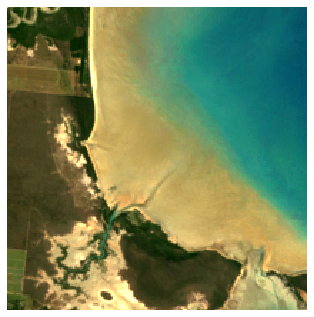

In [84]:
import numpy as np
from skimage.filters import unsharp_mask
from skimage.exposure import match_histograms, rescale_intensity, adjust_sigmoid

# funcs_list = [lambda x: match_histograms(image=x, reference=median_array, multichannel=True),
#               lambda x: x**0.5,
#               rescale_intensity,
#               hue_sat_val,
# #               lambda x: unsharp_mask(x, radius=50, amount=0.5),
# #               lambda x: unsharp_mask(x, radius=5, amount=0.3),
# #               lambda x: adjust_sigmoid(image=x, cutoff=0.5, gain=0.5),
#              ]
funcs_list = None

xr_animation(ds=ds_rolling.rename({'tide_height': 'time'}),
             output_path='animated_tides.gif',
             show_text='',
             bands=bands,
             interval=60,
             width_pixels=300,
             percentile_stretch=(0.01, 0.99),
             image_proc_funcs=funcs_list,
             show_date=False,
             annotation_kwargs={'fontsize': 30},
            ) 

In [ ]:
# Create copy and set time to time
data_tide = data.copy(deep=True)
data_tide['time'] = data_tide['tide_heights']
data_tide.rename({'time': 'tide'}, inplace=True)

# Extract ebb and flow stages as different datasets
filtered_flow = data_tide.where(data_tide.tide_phase == 'Flow', drop = True)
filtered_ebb = data_tide.where(data_tide.tide_phase == 'Ebb', drop = True)

# Sort flow by increasing tide height, and ebb by decreasing
filtered_flow = filtered_flow.sortby('tide')
filtered_ebb = filtered_ebb.sortby('tide', ascending=False)

# Drop categorical labels to allow rolling window
print(filtered_flow)
print(filtered_ebb)


In [164]:
ds_rolling = ds_ls.rolling(time=40, center=True, min_periods=1).median()
median_array = np.transpose(ds_rolling[bands]
                            .median(dim='time')
                            .to_array().values, 
                            axes=(1, 2, 0))
print(ds_rolling)

<xarray.Dataset>
Dimensions:      (time: 160, x: 303, y: 212)
Coordinates:
  * x            (x) float64 3.773e+05 3.773e+05 ... 3.803e+05 3.803e+05
  * time         (time) datetime64[ns] 2016-01-03T02:27:46.677000 ... 2020-08...
  * y            (y) float64 6.426e+06 6.426e+06 ... 6.424e+06 6.424e+06
    spatial_ref  int32 32750
Data variables:
    nbar_red     (time, y, x) float32 158.5 176.0 181.0 ... 117.0 126.5 120.0
    nbar_green   (time, y, x) float32 715.5 732.5 757.5 ... 277.5 276.5 283.0
    nbar_blue    (time, y, x) float32 622.5 629.0 639.5 ... 347.5 330.5 349.0


## DEA CoastLines data

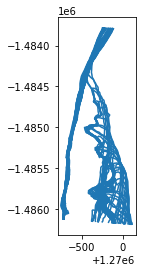

In [155]:
import geopandas as gpd
import pandas as pd
import matplotlib

# Get bounding box of data
xmin, ymin, xmax, ymax = ds_ls.geobox.geographic_extent.boundingbox

# Set up WFS requests for annual coastlines & rates of change statistics
deacl_coastlines_wfs = 'https://nonprod.geoserver.dea.ga.gov.au/geoserver/wfs?' \
                       'service=WFS&version=1.1.0&request=GetFeature&' \
                       'typeName=dea:coastlines&maxFeatures=1000&' \
                      f'bbox={ymin},{xmin},{ymax},{xmax},urn:ogc:def:crs:EPSG:4326'

# Load data from WFS and set CRS
deacl_gdf = gpd.read_file(deacl_coastlines_wfs)
deacl_gdf.crs = 'EPSG:3577'

# Clip to extent of satellite data
bbox = gpd.GeoDataFrame(geometry=[ds_ls.geobox.extent.geom],
                        crs=ds_ls.geobox.crs)  
deacl_gdf = gpd.overlay(deacl_gdf, bbox.to_crs(deacl_gdf.crs))
deacl_gdf = deacl_gdf.dissolve('year')

# Apply colours
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(deacl_gdf.index))
cmap = matplotlib.cm.get_cmap('inferno')
rgba = cmap(norm(deacl_gdf.reset_index().index))
deacl_gdf['color'] = list(rgba)
deacl_gdf['start_time'] = (pd.to_datetime(deacl_gdf.index) + 
                           pd.DateOffset(months=5))

# Remove a year
# deacl_gdf = deacl_gdf.drop('1993')

deacl_gdf.plot()

## Run animation

In [165]:
from skimage.color import rgb2hsv, hsv2rgb

def hue_sat_val(rgb_array,
                hue_mult=1, 
                sat_mult=0.8, 
                val_mult=1):   
    
    # Convert to HSV and multiply bands
    hsv_array = rgb2hsv(rgb_array)
    hsv_array[:, :, 0] = hsv_array[:, :, 0] * hue_mult
    hsv_array[:, :, 1] = hsv_array[:, :, 1] * sat_mult
    hsv_array[:, :, 2] = hsv_array[:, :, 2] * val_mult
    
    # Convert back to RGB
    return hsv2rgb(hsv_array.clip(0, 1))



In [138]:
import geopandas as gpd

# Specify bounding box
ymax, xmin = -33.6507, 115.2790
ymin, xmax = -33.6585, 115.3013

# Set up WFS requests for annual coastlines & rates of change statistics
deacl_coastlines_wfs = 'https://geoserver.dea.ga.gov.au/geoserver/wfs?' \
                       'service=WFS&version=1.1.0&request=GetFeature&' \
                       'typeName=dea:coastlines&srsName=EPSG%3A3577&' \
                       f'maxFeatures=1000&bbox={ymin},{xmin},{ymax},{xmax}'
deacl_statistics_wfs = 'https://geoserver.dea.ga.gov.au/geoserver/wfs?' \
                       'service=WFS&version=1.1.0&request=GetFeature&' \
                       'typeName=dea:coastlines_statistics&' \
                       'srsName=EPSG%3A3577&maxFeatures=1000&' \
                       f'bbox={ymin},{xmin},{ymax},{xmax}'

# Load DEA CoastLines data from WFS using geopandas
deacl_coastlines_gdf = gpd.read_file(deacl_coastlines_wfs)
deacl_statistics_gdf = gpd.read_file(deacl_statistics_wfs)

# Ensure CRSs are set correctly
deacl_coastlines_gdf.crs = 'EPSG:3577'
deacl_statistics_gdf.crs = 'EPSG:3577'

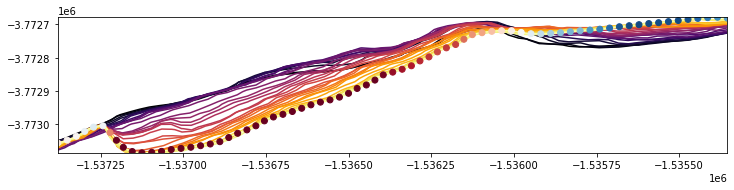